<a href="https://colab.research.google.com/github/unt-iialab/INFO5731_Spring2020/blob/master/Assignments/INFO5731_Assignment_Three.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **INFO5731 Assignment Three**

In this assignment, you are required to conduct information extraction, semantic analysis based on **the dataset you collected from assignment two**. You may use scipy and numpy package in this assignment.

# **Question 1: Understand N-gram**

(45 points). Write a python program to conduct N-gram analysis based on the dataset in your assignment two:

(1) Count the frequency of all the N-grams (N=3).

(2) Calculate the probabilities for all the bigrams in the dataset by using the fomular count(w2 w1) / count(w2). For example, count(really like) / count(really) = 1 / 3 = 0.33.

(3) Extract all the **noun phrases** and calculate the relative probabilities of each review in terms of other reviews (abstracts, or tweets) by using the fomular frequency (noun phrase) / max frequency (noun phrase) on the whole dataset. Print out the result in a table with column name the all the noun phrases and row name as all the 100 reviews (abstracts, or tweets). 


In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 27.9 MB/s 
     |████████████████████████████████| 182 kB 85.5 MB/s 
     |████████████████████████████████| 7.6 MB 61.7 MB/s 


In [2]:
# Write your code here
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import transformers
from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
import tensorflow as tf
from nltk.classify import NaiveBayesClassifier
from nltk.sentiment import SentimentAnalyzer
import nltk
from collections import Counter
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_selection import chi2
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, AdaBoostRegressor
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import numpy as np
import pandas as pd
import time
import pickle
import os
nltk.download('punkt')
nltk.download('wordnet')
warnings.simplefilter(action='ignore', category=FutureWarning)




[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [4]:
df = pd.read_csv("/content/sample_data/twitter.csv", on_bad_lines='skip')
df["'polarity'"] = df["'polarity'"].map({0: 0, 2: 1, 4: 2})
df.dropna(inplace=True)
pd.set_option('display.max_colwidth', None)
df.head(2)

,'polarity','id','date','query','user','text'
0,2,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,"@stellargirl I loooooooovvvvvveee my Kindle2. Not that the DX is cool, but the 2 is fantastic in its own right."
1,2,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs is good read.


In [5]:
train, test = train_test_split(df[["'text'", "'polarity'"]], random_state=0)
X_train = train["'text'"]
X_test = test["'text'"]
y_train = train["'polarity'"]
y_test = test["'polarity'"]

In [6]:
def get_accuracy():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    return round(accuracy_score(y_pred, y_test), 3)

# **Question 2: Undersand TF-IDF and Document representation**

(20 points). Starting from the documents (all the reviews, or abstracts, or tweets) collected for assignment two, write a python program: 

(1) To build the **documents-terms weights (tf*idf) matrix bold text**.

(2) To rank the documents with respect to query (design a query by yourself, for example, "An Outstanding movie with a haunting performance and best character development") by using **cosine similarity**.

In [7]:
# Write your code here
count_vectorizer = CountVectorizer(max_features=1000)
random_forest = RandomForestClassifier(max_depth=10, n_estimators=10)

In [8]:
pipe = make_pipeline(count_vectorizer, random_forest)

In [9]:
get_accuracy()

0.648

In [10]:
y_pred = pipe.predict(X_test)

In [11]:
round(pd.Series(y_train).value_counts(normalize=True), 2)

2    0.38
0    0.37
1    0.25
Name: 'polarity', dtype: float64

In [12]:
round(pd.Series(y_pred).value_counts(normalize=True), 2)

2    0.41
0    0.30
1    0.30
dtype: float64

In [13]:
random_forest.set_params(class_weight='balanced')
print(get_accuracy())
random_forest.set_params(class_weight='balanced_subsample')
print(get_accuracy())

0.568
0.648


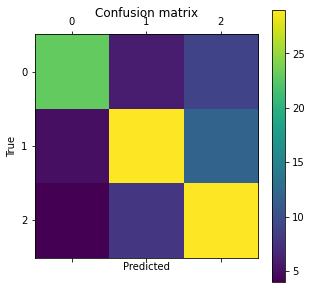

In [15]:
labels = [0, 1, 2]
y_pred = pipe.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=labels)
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [16]:
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer


class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()

    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

In [17]:
import nltk
nltk.download('omw-1.4')
pipe[0].set_params(tokenizer=LemmaTokenizer())
get_accuracy()

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


0.616

In [18]:
tfidf_vectorizer = TfidfVectorizer()
pipe.steps[0] = ('vectorizer', tfidf_vectorizer)
get_accuracy()

0.512

In [19]:
ada_boost = AdaBoostClassifier()
pipe.steps[1] = ('adaboost', ada_boost)
get_accuracy()

0.544

In [20]:
count_vectorizer.get_feature_names

<bound method CountVectorizer.get_feature_names of CountVectorizer(max_features=1000,
                tokenizer=<__main__.LemmaTokenizer object at 0x7fd451b20d90>)>

In [21]:
count_vectorizer = CountVectorizer()
bow = count_vectorizer.fit_transform(X_train)
words = count_vectorizer.get_feature_names()
p_value_limit = 0.95
dtf_features = pd.DataFrame()

for cat in range(3):
    _, p = chi2(bow, y_train == cat)
    dtf_features = dtf_features.append(pd.DataFrame(
        {"feature": words, "score": 1-p, "y": cat}))
    dtf_features = dtf_features.sort_values(["y", "score"],
                                            ascending=[True, False])
    dtf_features = dtf_features[dtf_features["score"] > p_value_limit]

X_names = dtf_features["feature"].unique().tolist()

pipe['vectorizer'].set_params(vocabulary=X_names)

get_accuracy()

0.624

In [22]:
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy',
                     mode='max', verbose=1, save_best_only=True)

In [23]:
def fit_sequential(X_train, X_test, sequential=None, epochs=20, patience=5):

    if sequential is None:
        input_size = X_train.shape[1]

        sequential = tf.keras.models.Sequential([
            tf.keras.layers.Flatten(input_shape=(input_size, )),
            tf.keras.layers.Dense(128),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(3, activation='sigmoid')
        ])
        loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
            from_logits=True)
        sequential.compile(optimizer='adam', loss=loss_fn,
                           metrics=['accuracy'])
        global mc
        mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy',
                             mode='max', verbose=1, save_best_only=True)

    es = EarlyStopping(monitor='val_accuracy', mode='max',
                       verbose=1, patience=patience)
    sequential.fit(X_train, np.array(y_train), epochs=epochs, verbose=1,
                   validation_data=(X_test, np.array(y_test)), callbacks=[es, mc])
    sequential.load_weights('best_model.h5')
    return sequential

In [24]:
vectorizer = TfidfVectorizer()
def convert_sparse_matrix_to_sparse_tensor(X):
    coo = X.tocoo()
    indices = np.mat([coo.row, coo.col]).transpose()
    return tf.sparse.reorder(tf.SparseTensor(indices, coo.data, coo.shape))
X_train_vectorized = vectorizer.fit_transform(X_train).toarray()
X_test_vectorized = vectorizer.transform(X_test).toarray()
sequential = fit_sequential(X_train_vectorized, X_test_vectorized)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


 1/12 [=>............................] - ETA: 8s - loss: 1.1137 - accuracy: 0.2500
Epoch 1: val_accuracy improved from -inf to 0.48000, saving model to best_model.h5
12/12 [==============================] - 1s 45ms/step - loss: 1.0879 - accuracy: 0.3700 - val_loss: 1.0775 - val_accuracy: 0.4800
Epoch 2/20
 1/12 [=>............................] - ETA: 0s - loss: 1.0323 - accuracy: 0.7188
Epoch 2: val_accuracy improved from 0.48000 to 0.52800, saving model to best_model.h5
12/12 [==============================] - 0s 10ms/step - loss: 0.9916 - accuracy: 0.7292 - val_loss: 1.0472 - val_accuracy: 0.5280
Epoch 3/20
 1/12 [=>............................] - ETA: 0s - loss: 0.8960 - accuracy: 0.8750
Epoch 3: val_accuracy improved from 0.52800 to 0.56800, saving model to best_model.h5
12/12 [==============================] - 0s 12ms/step - loss: 0.8978 - accuracy: 0.7962 - val_loss: 1.0156 - val_accuracy: 0.5680
Epoch 4/20
11/12 [==========================>...] - ETA: 0s - loss: 0.7993 - accurac

# **Question 3: Create your own word embedding model**

(20 points). Use the data you collected for assignment two to build a word embedding model: 

(1) Train a 300-dimension word embedding (it can be word2vec, glove, ulmfit, bert, or others).

(2) Visualize the word embedding model you created.

Reference: https://machinelearningmastery.com/develop-word-embeddings-python-gensim/

Reference: https://jaketae.github.io/study/word2vec/

In [25]:
# Write your code here
class W2VTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, size):
        self.size = size
        pass

    def fit(self, X, y=None):
        self.model = Word2Vec(min_count=1,
                              window=2,
                              size=self.size,
                              sample=6e-5,
                              alpha=0.03,
                              min_alpha=0.0007,
                              negative=20)
        sentences = [row.split() for row in X]

        self.model.build_vocab(sentences)
        self.model.train(
            sentences, total_examples=self.model.corpus_count, epochs=self.model.epochs)
        return self

    def get_vector(self, sentence):
        relevant_words_vectors = [self.model.wv[x]
                                  for x in sentence.split() if x in self.model.wv.vocab]
        if not relevant_words_vectors:
            return np.zeros(self.model.vector_size)  # .astype('float32')
        return np.mean(relevant_words_vectors, axis=0)

    def transform(self, X):
        arr = np.array([])
        for elem in X:
            arr = np.concatenate([arr, self.get_vector(elem)])
        return arr.reshape(-1, self.size)

In [26]:
vectorizer = W2VTransformer(4)
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

In [27]:
sequential = fit_sequential(X_train_vectorized, X_test_vectorized)

Epoch 1/20
 1/12 [=>............................] - ETA: 3s - loss: 1.0956 - accuracy: 0.4375
Epoch 1: val_accuracy improved from -inf to 0.28800, saving model to best_model.h5
12/12 [==============================] - 0s 15ms/step - loss: 1.0960 - accuracy: 0.3324 - val_loss: 1.1077 - val_accuracy: 0.2880
Epoch 2/20
 1/12 [=>............................] - ETA: 0s - loss: 1.0897 - accuracy: 0.2812
Epoch 2: val_accuracy improved from 0.28800 to 0.32000, saving model to best_model.h5
12/12 [==============================] - 0s 4ms/step - loss: 1.0890 - accuracy: 0.3512 - val_loss: 1.1156 - val_accuracy: 0.3200
Epoch 3/20
 1/12 [=>............................] - ETA: 0s - loss: 1.0660 - accuracy: 0.3438
Epoch 3: val_accuracy did not improve from 0.32000
12/12 [==============================] - 0s 5ms/step - loss: 1.0838 - accuracy: 0.3673 - val_loss: 1.1229 - val_accuracy: 0.3040
Epoch 4/20
 1/12 [=>............................] - ETA: 0s - loss: 1.0837 - accuracy: 0.3438
Epoch 4: val_acc

In [28]:
pca = PCA(n_components=2)
X_train_vectorized_2d = pca.fit_transform(X_train_vectorized)

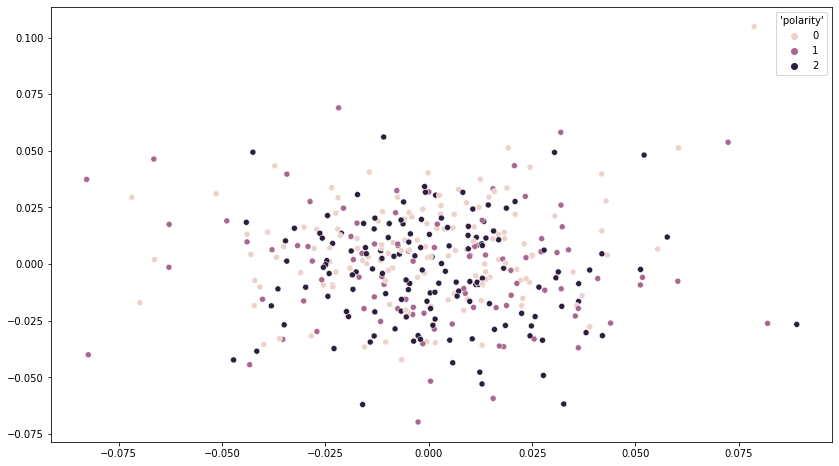

In [29]:
plt.figure(figsize=(14, 8))
_ = sns.scatterplot(
    X_train_vectorized_2d[:, 0], X_train_vectorized_2d[:, 1], hue=y_train)

# **Question 4: Create your own training and evaluation data for sentiment analysis**

(15 points). **You dodn't need to write program for this question!** Read each review (abstract or tweet) you collected in detail, and annotate each review with a sentiment (positive, negative, or neutral). Save the annotated dataset into a csv file with three columns (first column: document_id, clean_text, sentiment), upload the csv file to GitHub and submit the file link blew. This datset will be used for assignment four: sentiment analysis and text classification. 


In [30]:
model_class, tokenizer_class, pretrained_weights = (
    transformers.DistilBertModel, transformers.DistilBertTokenizer, 'distilbert-base-uncased')
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [31]:
def get_vectors():
    start = time.time()
    k = 1000
    for i in range(0, len(all_sentences), k):
        with torch.no_grad():
            last_hidden_states = model(
                input_ids[i:i+k], attention_mask=input_ids[i:i+k])
        vectors = np.concatenate([vectors, last_hidden_states[0].numpy(
        )[:, 0, :]]) if i > 0 else last_hidden_states[0].numpy()[:, 0, :]
    return vectors

In [32]:
sequential = fit_sequential(X_train_vectorized, X_test_vectorized, epochs=10)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


 1/12 [=>............................] - ETA: 6s - loss: 1.0969 - accuracy: 0.3438
Epoch 1: val_accuracy improved from -inf to 0.32800, saving model to best_model.h5
12/12 [==============================] - 1s 25ms/step - loss: 1.0937 - accuracy: 0.3834 - val_loss: 1.1067 - val_accuracy: 0.3280
Epoch 2/10
 1/12 [=>............................] - ETA: 0s - loss: 1.1023 - accuracy: 0.3125
Epoch 2: val_accuracy did not improve from 0.32800
12/12 [==============================] - 0s 5ms/step - loss: 1.0862 - accuracy: 0.3780 - val_loss: 1.1136 - val_accuracy: 0.3280
Epoch 3/10
 1/12 [=>............................] - ETA: 0s - loss: 1.0852 - accuracy: 0.5000
Epoch 3: val_accuracy improved from 0.32800 to 0.34400, saving model to best_model.h5
12/12 [==============================] - 0s 12ms/step - loss: 1.0814 - accuracy: 0.4290 - val_loss: 1.1202 - val_accuracy: 0.3440
Epoch 4/10
 1/12 [=>............................] - ETA: 0s - loss: 1.0999 - accuracy: 0.4062
Epoch 4: val_accuracy did 

In [33]:
vectorizer = W2VTransformer(4)
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)
sequential = fit_sequential(X_train_vectorized, X_test_vectorized)
mapper = {0: "negative", 1: "neutral", 2: "positive"}
def get_sentiment(model, vectorizer, mapper, text):
    return mapper.get(np.argmax(max(model.predict(vectorizer.transform(pd.Series([text]))))))

Epoch 1/20
 1/12 [=>............................] - ETA: 4s - loss: 1.0986 - accuracy: 0.4375
Epoch 1: val_accuracy improved from -inf to 0.37600, saving model to best_model.h5
12/12 [==============================] - 1s 39ms/step - loss: 1.0940 - accuracy: 0.3807 - val_loss: 1.1042 - val_accuracy: 0.3760
Epoch 2/20
10/12 [========================>.....] - ETA: 0s - loss: 1.0847 - accuracy: 0.3844
Epoch 2: val_accuracy improved from 0.37600 to 0.38400, saving model to best_model.h5
12/12 [==============================] - 0s 13ms/step - loss: 1.0854 - accuracy: 0.3968 - val_loss: 1.1117 - val_accuracy: 0.3840
Epoch 3/20
 1/12 [=>............................] - ETA: 0s - loss: 1.0750 - accuracy: 0.4062
Epoch 3: val_accuracy improved from 0.38400 to 0.39200, saving model to best_model.h5
12/12 [==============================] - 0s 13ms/step - loss: 1.0815 - accuracy: 0.4316 - val_loss: 1.1202 - val_accuracy: 0.3920
Epoch 4/20
 1/12 [=>............................] - ETA: 0s - loss: 1.086

In [36]:
get_sentiment(sequential, vectorizer, mapper, "I am living with abundance")

1/1 [==============================] - 0s 21ms/step


'positive'

In [ ]:
# The GitHub link of your final csv file
https://github.com/Shylesh1/INFO-5731-Computational/blob/main/twitter.csv

# Link: 
https://github.com/Shylesh1/INFO-5731-Computational

